# Full prep a scan

In [12]:
from importlib import metadata
import sys
from pathlib import Path
import numpy as np

sys.path.append('../utilities')
sys.path.append('../models/grt123')
sys.path.append('../models/grt123/training')
sys.path.append('../models/grt123/preprocessing/')

from full_prep import savenpy_summit

scan_id = '1.3.6.1.4.1.14519.5.2.1.6279.6001.312127933722985204808706697221'

scanpath_list = [scan_path for scan_path in Path('../scans/luna16/mhd').glob('**/*.mhd')]

ids = sorted([scan_path.stem.replace('.mhd','') for scan_path in scan_path_list])

print(ids)

idx = ids.index(scan_id)

print(idx)

prep_folder = Path('/Users/john/Projects/SOTAEvaluationNoduleDetection/models/grt123/prep_result')
metadata_path = Path('/Users/john/Projects/SOTAEvaluationNoduleDetection/output/metadata/luna/test_fold1_metadata.csv')

savenpy_summit(idx, scanpath_list, prep_folder, use_existing=True, metadata_path=metadata_path)

label = np.load(prep_folder / f'{scan_id}_label.npy')

print(label)

['1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748', '1.3.6.1.4.1.14519.5.2.1.6279.6001.250397690690072950000431855143', '1.3.6.1.4.1.14519.5.2.1.6279.6001.270390050141765094612147226290', '1.3.6.1.4.1.14519.5.2.1.6279.6001.312127933722985204808706697221', '1.3.6.1.4.1.14519.5.2.1.6279.6001.749871569713868632259874663577', '1.3.6.1.4.1.14519.5.2.1.6279.6001.765930210026773090100532964804', '1.3.6.1.4.1.14519.5.2.1.6279.6001.771741891125176943862272696845', '1.3.6.1.4.1.14519.5.2.1.6279.6001.771831598853841017505646275338', '1.3.6.1.4.1.14519.5.2.1.6279.6001.837810280808122125183730411210', '1.3.6.1.4.1.14519.5.2.1.6279.6001.855232435861303786204450738044', '1.3.6.1.4.1.14519.5.2.1.6279.6001.897279226481700053115245043064', '1.3.6.1.4.1.14519.5.2.1.6279.6001.900182736599353600185270496549', '1.3.6.1.4.1.14519.5.2.1.6279.6001.927394449308471452920270961822']
3
Preparing ... 1.3.6.1.4.1.14519.5.2.1.6279.6001.771741891125176943862272696845
1.3.6.1.4.1.14519.5.2.1.6279.6001.

# Check nodule locations of MHD and GRT123 Clean/ Label are consistent

Scan already exists locally
(5, 5)


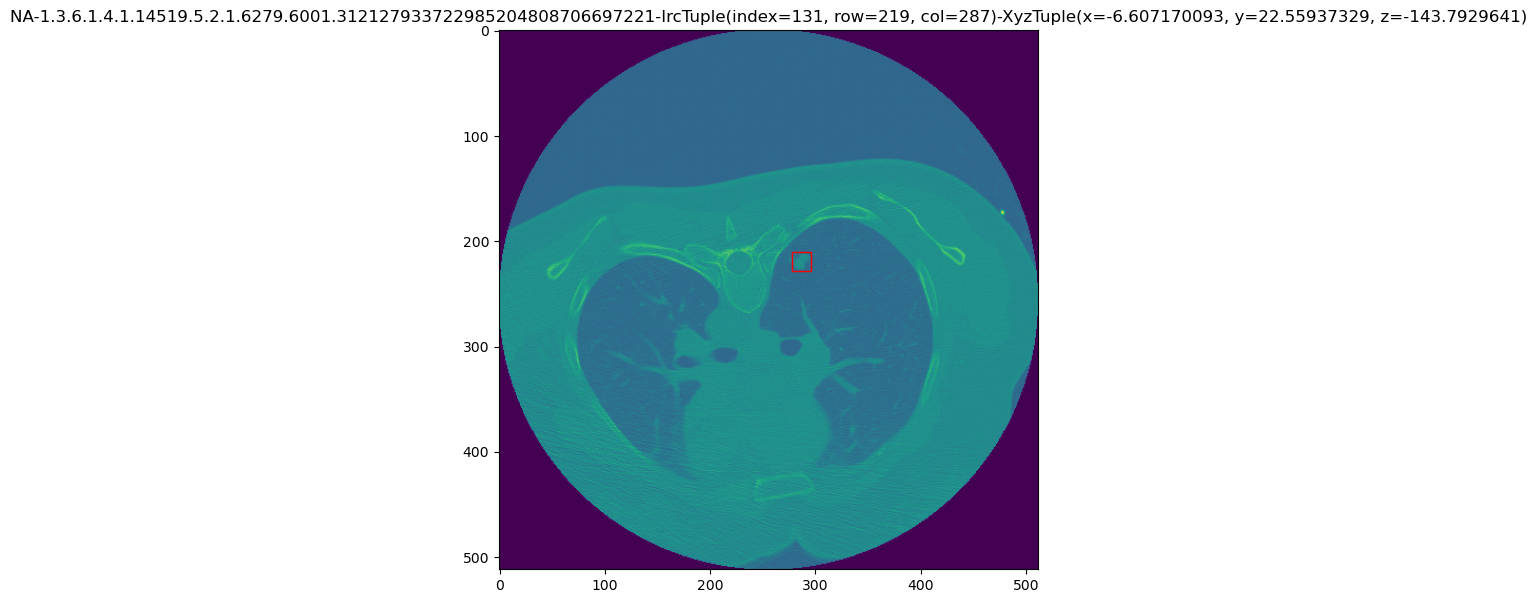

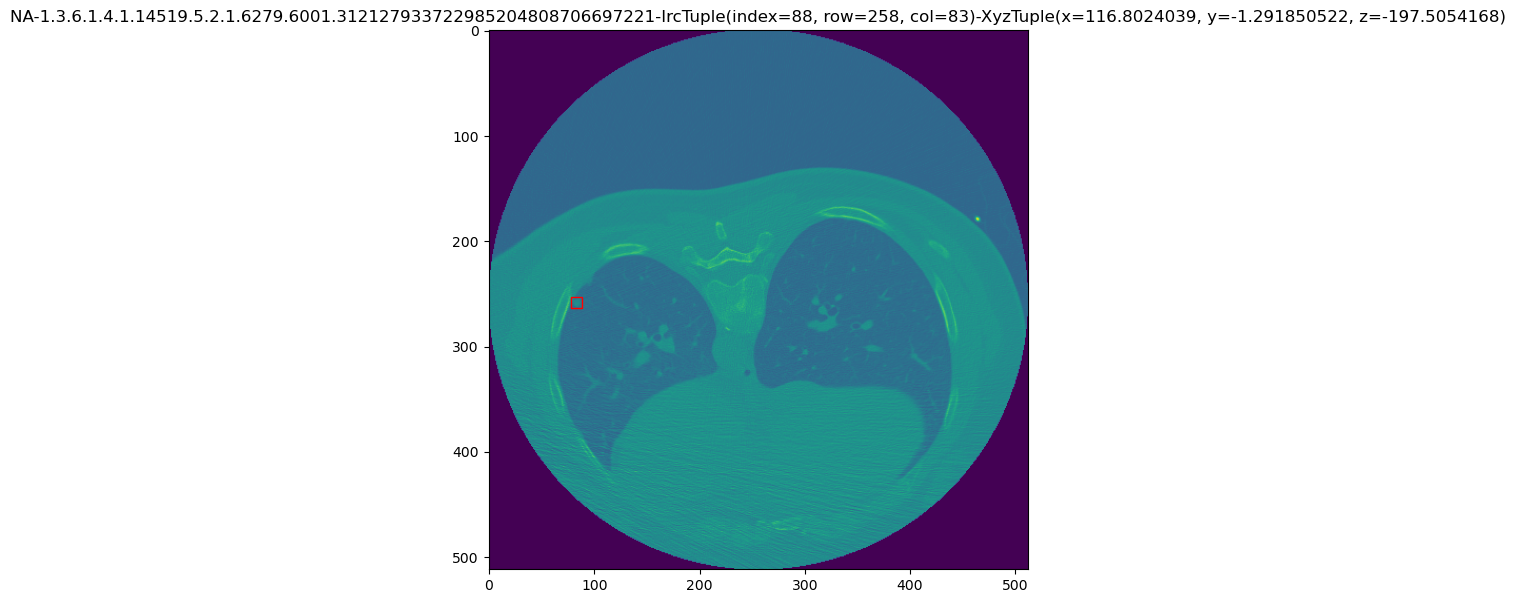

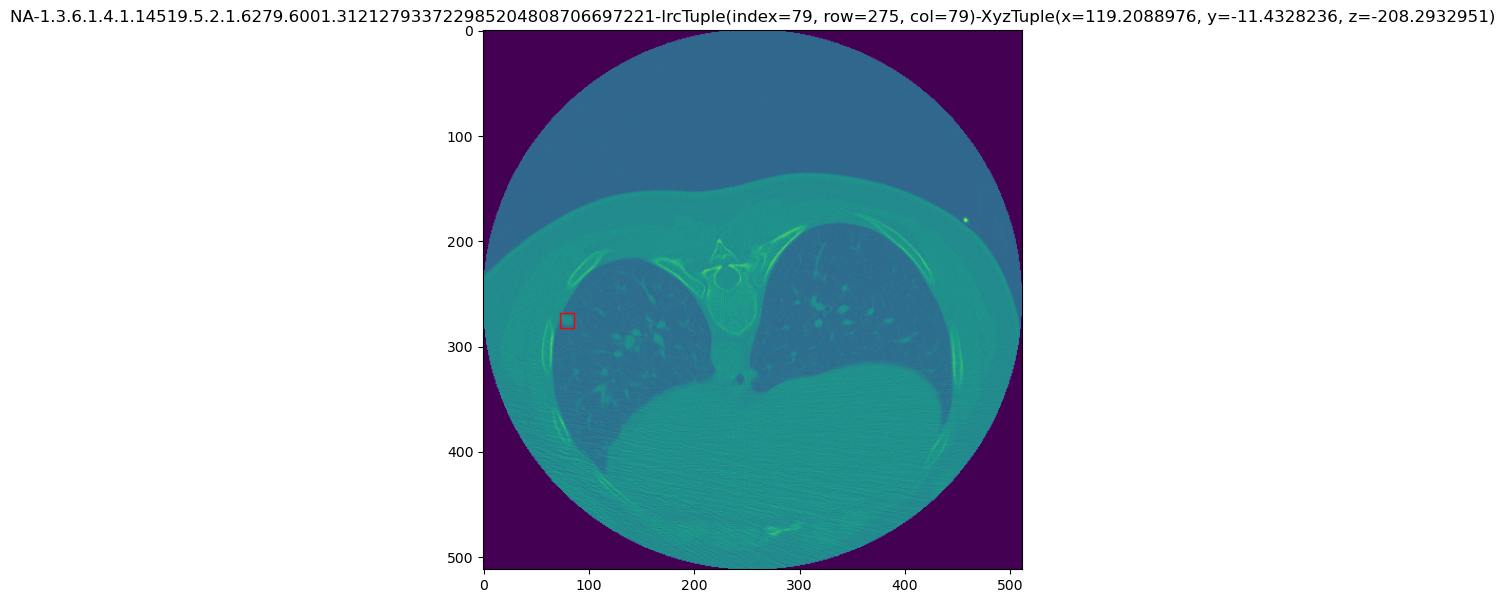

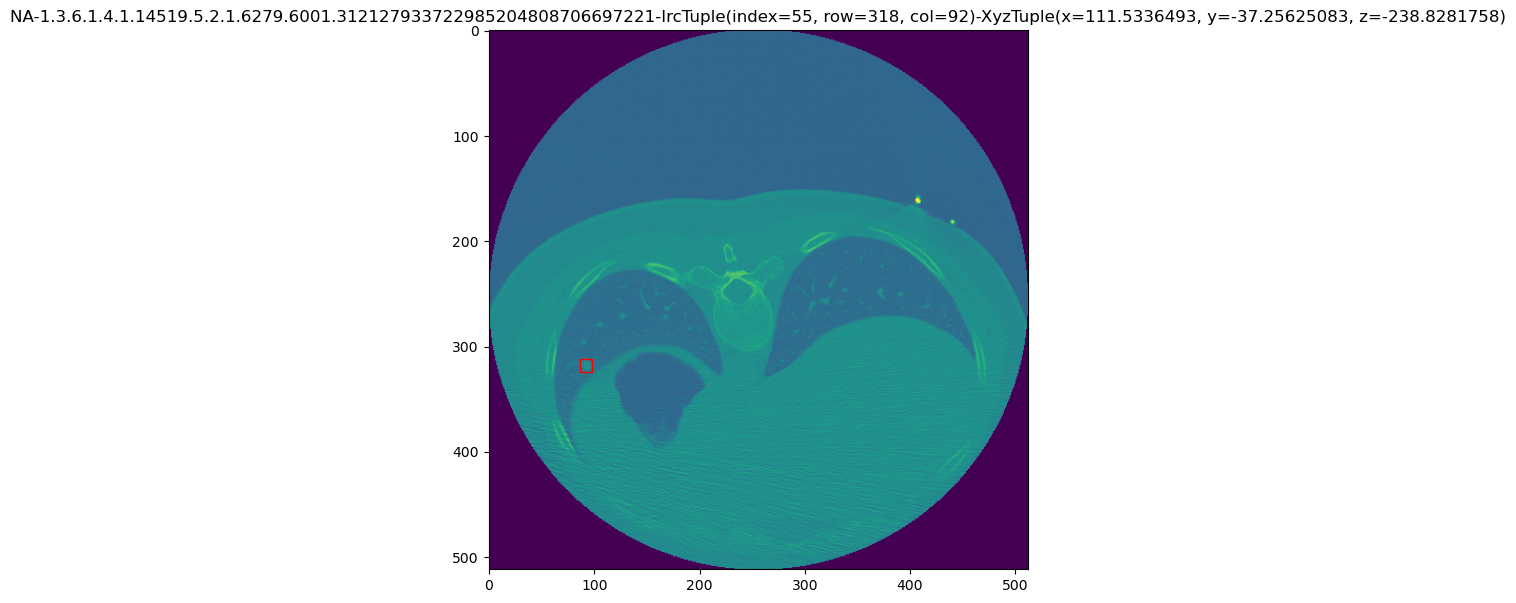

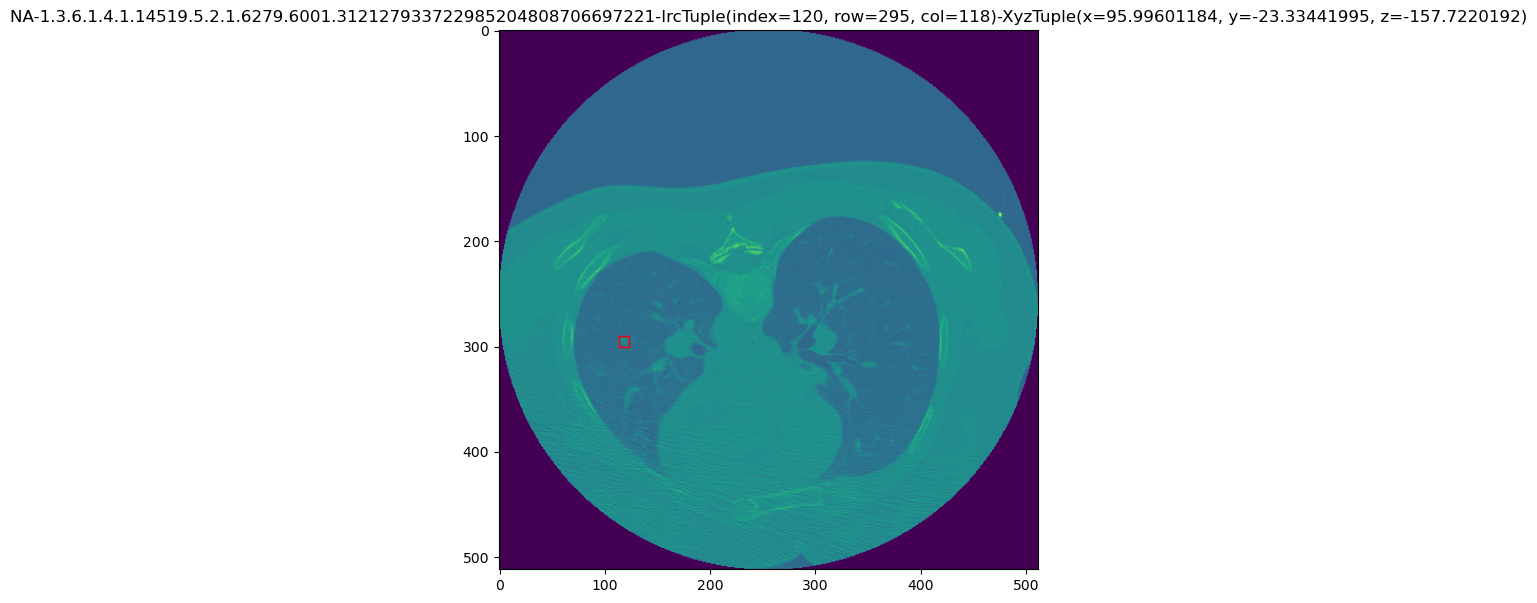

Clean and label already exists locally


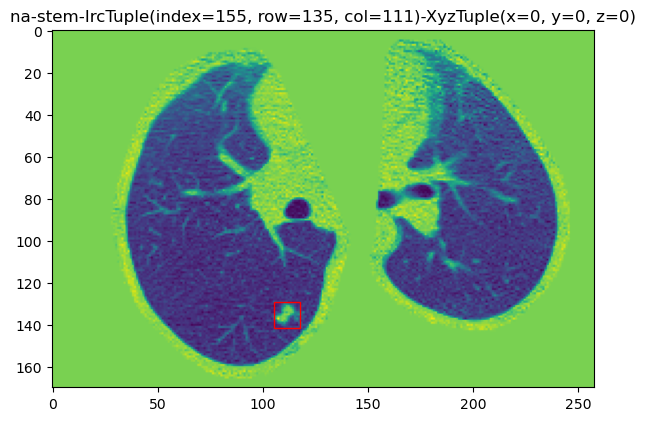

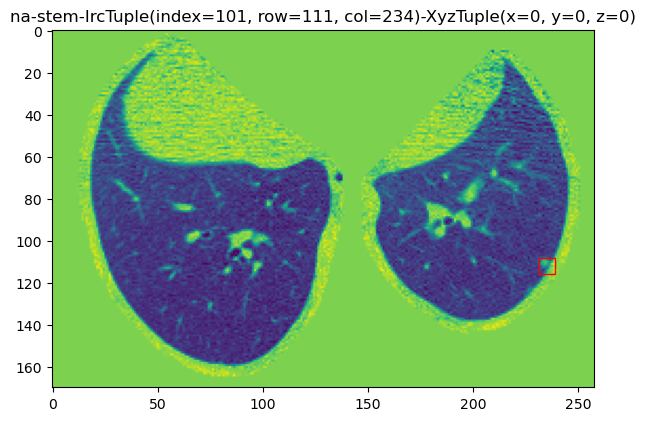

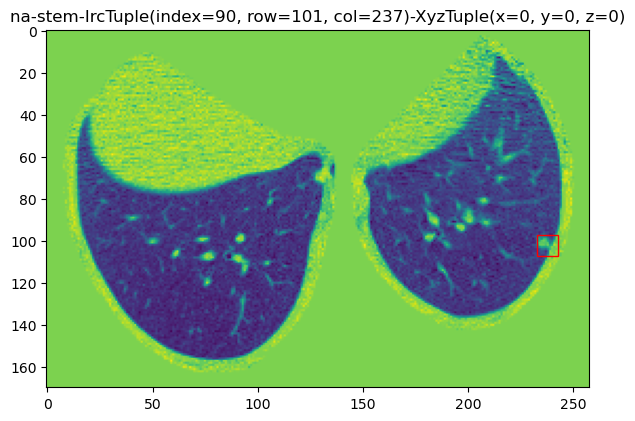

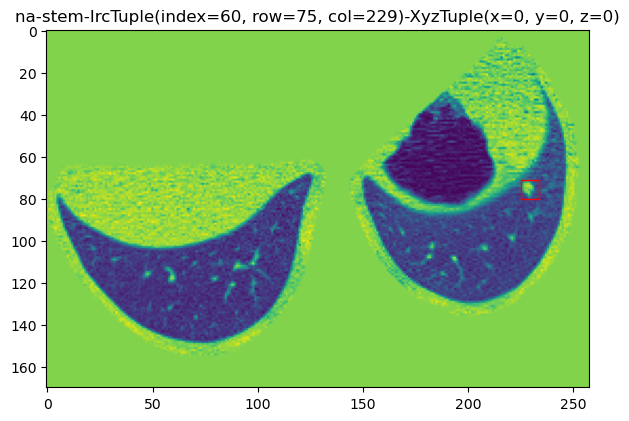

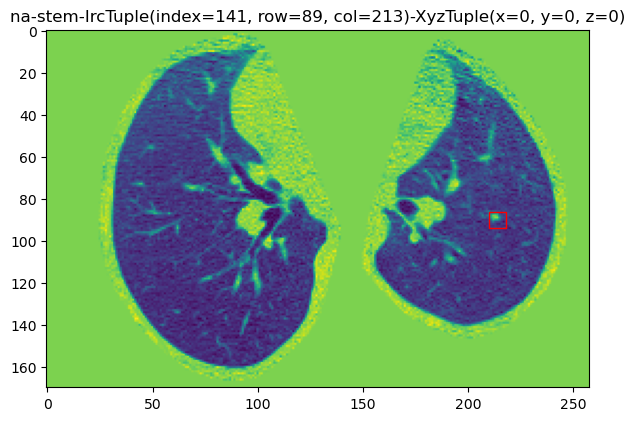

In [4]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from pathlib import Path
import subprocess
import SimpleITK as sitk
from typing import List


DisplayTuple = namedtuple('DisplayTuple',['nodule_type','scan_id', 'image', 'xyz_coords', 'irc_coords', 'diameter'])

IrcTuple = namedtuple('IrcTuple',['index','row','col'])

XyzTuple = namedtuple('XyzTuple',['x','y','z'])

class SummitScan:
    """
    Author: John McCabe
    Description:  

    Attributes:
        pixel_array
        voxel_size
        origin
        orientation
    """
    def __init__(self, scan_uid, metadata, image) -> None:
        super().__init__()
        self.scan_uid = scan_uid
        self.metadata = metadata
        self.image = image

        # Pull out the salient bits of info needed
        self.origin = self.metadata.GetOrigin()
        self.voxel_size = self.metadata.GetSpacing()
        self.orientation = np.array(self.metadata.GetDirection()).reshape(3,3)

    @classmethod
    def load_scan(cls, path, type='MetaImageIO'):
        """
        Loads the scan from raw. Keeps all properties as part of the slices. 
        """

        # unique identifier can be found from file name
        scan_uid = Path(path).name.split('.')[0]

        # read in the scan
        if type == 'MetaImageIO':
            metadata = sitk.ReadImage(path)
            image = np.array(sitk.GetArrayFromImage(metadata), dtype=np.float32)

        return cls(scan_uid, metadata, image)

def xyz2irc(coord_xyz, origin, voxel_size, orientation=np.array([[1,0,0],[0,1,0],[0,0,1]])):

    origin_a = np.array(origin)
    voxel_size_a = np.array(voxel_size)
    coord_a = np.array(coord_xyz)

    cri_a = ((coord_a - origin_a) @ np.linalg.inv(orientation)) / voxel_size_a
    
    # it can only be whole numbers as irc
    cri_a = np.round(cri_a)
    return IrcTuple(index=int(cri_a[2]), row=int(cri_a[1]), col=int(cri_a[0]))

def irc2xyz(coord_irc, origin_xyz, vxSize_xyz, direction_a):
    cri_a = np.array(coord_irc)[::-1]
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coords_xyz = (direction_a @ (cri_a * vxSize_a)) + origin_a
    # coords_xyz = (direction_a @ (idx * vxSize_a)) + origin_a
    return XyzTuple(*coords_xyz)

def display_images(nodule_type_images):

    for idx, display_tuple in enumerate(nodule_type_images):
        image = display_tuple.image
        xyz = display_tuple.xyz_coords
        irc = display_tuple.irc_coords
        diameter = display_tuple.diameter

        fig, ax = plt.subplots(nrows=1,ncols=1)
        fig.set_size_inches(7,7)

        ax.imshow(image[irc.index,:,:])
        rect = patches.Rectangle((int(irc.col-((diameter+3)//2)), int(irc.row-((diameter+3)//2))),
                                 width=diameter+3,
                                 height=diameter+3,
                                 linewidth=1,
                                 edgecolor='r',
                                 facecolor='none')
        
        ax.add_patch(rect)
        ax.set_title(display_tuple.nodule_type + '-' + display_tuple.scan_id + '-' + str(irc) + '-' + str(xyz))
        plt.show()

def copy_scan_from_remote_to_local(study_id):
    # Define the source and destination paths
    source_path = f"jmccabe@localhost:/cluster/project2/SummitLung50/{study_id}/{study_id}_Y0_BASELINE_A.*"
    destination_path = f"../scans/SummitLung50/{study_id}/."

    Path(destination_path).mkdir(parents=True, exist_ok=True)

    # Execute the SCP command
    if not Path(destination_path, f"{study_id}_Y0_BASELINE_A.mhd").exists():
        subprocess.run(["scp", "-P", "2222", source_path, destination_path])
    else:
        print("File already exists locally")

def copy_clean_and_label_from_remote_to_local(study_id):
    # Define the source and destination paths
    source_path = f"jmccabe@localhost:/cluster/project2/SUMMIT/cache/grt123/prep_result/{study_id}_Y0_BASELINE_A_*"
    destination_path = f"../models/grt123/prep_result/."

    # Execute the SCP command
    if not Path(destination_path, f"{study_id}_Y0_BASELINE_A_clean.npy").exists():
        print("Copying clean", source_path, destination_path)
        subprocess.run(["scp", "-P", "2222", source_path, destination_path])

def display_original_nodules(scan_path, metadata_path, study_id):
    
    scan = SummitScan.load_scan(scan_path)

    nodules = pd.read_csv(metadata_path)
    nodules = nodules[nodules.scan_id==study_id]

    print(nodules.shape)

    nodule_type_images = []
    for idx, row in nodules.iterrows():

        nodule_xyz = XyzTuple(x=row['nodule_x_coordinate'],
                                y=row['nodule_y_coordinate'],
                                z=row['nodule_z_coordinate'])
        
        nodule_irc = xyz2irc(coord_xyz=nodule_xyz,
                                origin=scan.origin,
                                voxel_size=scan.voxel_size,
                                orientation=scan.orientation)

        
        nodule_diameter = row['nodule_diameter_mm'] if row['nodule_diameter_mm'] else row['nodule_subsolid_major_axis_diameter']
        
        nodule_type_images.append(DisplayTuple(nodule_type='NA',
                                    scan_id=study_id,
                                    image=scan.image,
                                    xyz_coords=nodule_xyz,
                                    irc_coords=nodule_irc,
                                    diameter=int(nodule_diameter //scan.voxel_size[1]) ))

    display_images(nodule_type_images)

def display_processed_nodules(scan_path):

    clean = np.load(scan_path)
    nodules = np.load(scan_path.replace('clean', 'label'))

    nodule_type_images = []
    for nodule in nodules:

        xyz = XyzTuple(x=0, y=0, z=0)
        irc = IrcTuple(index=int(nodule[0]), col=int(nodule[2]), row=int(nodule[1]))
        d = nodule[3]

        nodule_type_images.append(DisplayTuple(nodule_type='na',
                                               scan_id='stem',
                                               image=clean[0,...],
                                               xyz_coords=xyz,
                                               irc_coords=irc,
                                               diameter=d))

    display_images(nodule_type_images)

def get_random_scan_id(name, dataset):
    """
    Returns a random scan id from the specified scan type. 
    """
    # Get the list of all scan ids
    scan_ids = pd.read_csv(f'../output/metadata/{name}/{dataset}_metadata.csv')['scan_id'].unique()

    # Return a random scan id
    return scan_ids[np.random.randint(len(scan_ids))]

def main():

    # scan_id = get_random_scan_id('reduced', 'training')
    # print(scan_id)

    scan_id = "1.3.6.1.4.1.14519.5.2.1.6279.6001.312127933722985204808706697221"

    original_image_path = f'/Users/john/Projects/SOTAEvaluationNoduleDetection/scans/luna16/mhd/1.3.6.1.4.1.14519.5.2.1.6279.6001.312127933722985204808706697221.mhd'

    if not Path(original_image_path).exists():
        print("Copying scan from remote to local")
        copy_scan_from_remote_to_local(scan_id)
    else:
        print("Scan already exists locally")

    display_original_nodules(
        original_image_path, 
        f'/Users/john/Projects/SOTAEvaluationNoduleDetection/output/metadata/luna/test_fold1_metadata.csv',
        scan_id
    )


    processed_image_path = f'/Users/john/Projects/SOTAEvaluationNoduleDetection/models/grt123/prep_result/1.3.6.1.4.1.14519.5.2.1.6279.6001.312127933722985204808706697221_clean.npy'

    if not Path(processed_image_path).exists():
        print("Copying clean and label from remote to local")
        copy_clean_and_label_from_remote_to_local(scan_id)
    else:
        print("Clean and label already exists locally")

    display_processed_nodules(processed_image_path)

main()


# Check why some of the images fail when dataloading

In [23]:
# Labels check
import pandas as pd

labels_d = {}
labels = []
for idx, label in enumerate(Path('../models/grt123/prep_result/').glob('*label.npy')):
    labels_d[idx] = label.stem
    labels.append(np.load(label))

bboxes = []
for idx, label in enumerate(labels):
    if len(label) > 0:
        
        for t in label:
            bboxes.append([np.concatenate([[idx],t])])

pd.DataFrame(np.array(bboxes).squeeze(1)).to_csv('bboxes.csv', index=False)




In [26]:
for i in [17,
26,
290,
337,
439,
460,
533,
639,
767,
775,
854]:
    print(labels_d[i].replace('_label',''))


1.3.6.1.4.1.14519.5.2.1.6279.6001.312127933722985204808706697221
1.3.6.1.4.1.14519.5.2.1.6279.6001.127965161564033605177803085629
1.3.6.1.4.1.14519.5.2.1.6279.6001.123697637451437522065941162930
1.3.6.1.4.1.14519.5.2.1.6279.6001.144883090372691745980459537053
1.3.6.1.4.1.14519.5.2.1.6279.6001.148447286464082095534651426689
1.3.6.1.4.1.14519.5.2.1.6279.6001.801945620899034889998809817499
1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561266624992539111877
1.3.6.1.4.1.14519.5.2.1.6279.6001.219349715895470349269596532320
1.3.6.1.4.1.14519.5.2.1.6279.6001.282512043257574309474415322775
1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311
1.3.6.1.4.1.14519.5.2.1.6279.6001.177252583002664900748714851615


[[  96.5790857  -217.5030578  -138.86185583    3.6626963 ]
 [ 196.07195767 -251.67898028 -268.80979625    3.55934893]
 [ 182.4322839  -304.22368795 -287.58395715    6.10297138]
 [ 164.6897518  -246.70094078 -257.96859584   16.51200852]
 [ 107.869856   -245.714996   -244.03297262    2.9398976 ]
 [  79.9272913  -281.3976815  -294.46256865    3.34842396]]


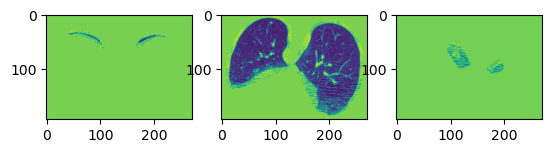

In [15]:
import numpy as np

img_path = '/Users/john/Projects/SOTAEvaluationNoduleDetection/models/grt123/prep_result/1.3.6.1.4.1.14519.5.2.1.6279.6001.148447286464082095534651426689_clean.npy'

img = np.load(img_path)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1,ncols=3)

ax[0].imshow(img[0,0,:,:])
ax[1].imshow(img[0,img.shape[2] // 2,:,:])
ax[2].imshow(img[0,-1,:,:])

lbl_path = img_path.replace('clean', 'label')
lbl = np.load(lbl_path)

print(lbl)

In [64]:
sizelim = 3
sizelim2 = 4
sizelim3 = 5

idcs = [
    [[1,2,3,4], [5,6,7,6]],
    [[9,10,11,1], [13,14,15,2]],
    [[17,18,19,2], [21,22,23,5]],
]

labels = []
for idx in idcs:
    l = idx
    if np.all(l==0):
        l=np.array([])
    labels.append(l)


print(labels)

sample_bboxes = labels
bboxes = []
for i, l in enumerate(labels):
    if len(l) > 0 :
        for t in l:
            if t[3]>sizelim:
                bboxes.append([np.concatenate([[i],t])])
            if t[3]>sizelim2:
                bboxes+=[[np.concatenate([[i],t])]]*2
            if t[3]>sizelim3:
                bboxes+=[[np.concatenate([[i],t])]]*4
bboxes = np.concatenate(bboxes,axis = 0)

print(bboxes)

[[[1, 2, 3, 4], [5, 6, 7, 6]], [[9, 10, 11, 1], [13, 14, 15, 2]], [[17, 18, 19, 2], [21, 22, 23, 5]]]
[[ 0  1  2  3  4]
 [ 0  5  6  7  6]
 [ 0  5  6  7  6]
 [ 0  5  6  7  6]
 [ 0  5  6  7  6]
 [ 0  5  6  7  6]
 [ 0  5  6  7  6]
 [ 0  5  6  7  6]
 [ 2 21 22 23  5]
 [ 2 21 22 23  5]
 [ 2 21 22 23  5]]


# GRT123 organising the data into folds, so that we can

1. prepare data much quicker
2. split into folds as per LUNA competition

In [6]:
import pandas as pd
from pathlib import Path
import numpy as np

root = Path('/Users/john/Projects/SOTAEvaluationNoduleDetection/output/metadata/luna')

# Read the CSV file
df = pd.read_csv(Path(root, 'annotations.csv'))

scan_ids = (
    pd.read_csv(Path(root, 'luna_scans.txt'), header=None)[0].str.replace('.mhd','').values
)

print(f"Total scans: {len(scan_ids)}")

# Split the scan_ids list into 10 smaller lists

how_many = 5

split_scan_ids = [scan_ids[i::how_many] for i in range(how_many)]

# Print the split scan_ids lists
for i, split_list in enumerate(split_scan_ids):
    print(f"Split {i+1}: {len(split_list)}")

for i, split_list in enumerate(split_scan_ids):

    pd.DataFrame(split_list).rename(columns={0:'scan_id'}).to_csv(Path(root, f'fold{i+1}_scans.csv'), index=False)

    df_split = df[df['seriesuid'].isin(split_list)]
    df_split = df_split.rename(
        columns={
            'seriesuid' : 'scan_id',
            'coordX' : 'nodule_x_coordinate',
            'coordY' : 'nodule_y_coordinate',
            'coordZ' : 'nodule_z_coordinate',
            'diameter_mm' : 'nodule_diameter_mm'
        }
    )
    df_split.to_csv(Path(root, f'fold{i+1}_metadata.csv'), index=False)

Total scans: 888
Split 1: 178
Split 2: 178
Split 3: 178
Split 4: 177
Split 5: 177


/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/ipykernel_93860/1644047586.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  pd.read_csv(Path(root, 'luna_scans.txt'), header=None)[0].str.replace('.mhd','').values


In [7]:
from pathlib import Path
import pandas as pd
import copy

# combine into 10 folds as per competition

root = Path('/Users/john/Projects/SOTAEvaluationNoduleDetection/output/metadata')

metadata = []
scans = []

how_many = 5


for i in range(how_many):
    metadata.append(pd.read_csv(f'../output/metadata/luna/fold{i+1}_metadata.csv'))
    scans.append(pd.read_csv(f'../output/metadata/luna/fold{i+1}_scans.csv'))


print(len(metadata))
print(len(scans))

for i in range(how_many):
    fold_metadata = copy.copy(metadata)
    fold_scans = copy.copy(scans)


    del fold_metadata[i]
    del fold_scans[i]

    training_metadata = pd.concat(fold_metadata)
    training_scans = pd.concat(fold_scans)

    validation_metadata = metadata[i]
    validation_scans = scans[i]

    Path(root, f'luna_fold{i+1}').mkdir(parents=True, exist_ok=True)

    training_metadata.to_csv(Path(root, f'luna_fold{i+1}/training_metadata.csv'), index=False)
    training_scans.to_csv(Path(root, f'luna_fold{i+1}/training_scans.csv'), index=False)

    validation_metadata.to_csv(Path(root, f'luna_fold{i+1}/validation_metadata.csv'), index=False)
    validation_scans.to_csv(Path(root, f'luna_fold{i+1}/validation_scans.csv'), index=False)




5
5


In [19]:
# Split the SUMMIT test scans so that they can be quickly evaluated

root = Path('/Users/john/Projects/SOTAEvaluationNoduleDetection/output/metadata/reduced')

# Read the CSV file
df = pd.read_csv(Path(root, 'test_metadata.csv'))

scan_ids = (
    pd.read_csv(Path(root, 'test_scans.csv'))['scan_id'].str.split('_',n=1).str[0].values
)

print(f"Total scans: {len(scan_ids)}, {scan_ids[:5]}")

# Split the scan_ids list into 10 smaller lists

how_many = 10

split_scan_ids = [scan_ids[i::how_many] for i in range(how_many)]

# Print the split scan_ids lists
tot = 0
for i, split_list in enumerate(split_scan_ids):
    pd.DataFrame([study_id + '_Y0_BASELINE_A' for study_id in split_list]).rename(columns={0:'scan_id'}).to_csv(Path(root, f'fold{i+1}_scans.csv'), index=False)

    df_split = df[df['participant_id'].isin(split_list)]
    df_split.loc[:, 'scan_id'] = df_split['participant_id'].apply(lambda s: s + '_Y0_BASELINE_A')
    df_split.to_csv(Path(root, f'fold{i+1}_metadata.csv'), index=False)

print(tot)

Total scans: 595, ['summit-2225-fhj' 'summit-2233-uty' 'summit-2275-fpj' 'summit-2299-ndz'
 'summit-2336-efe']
0


/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/ipykernel_77682/2819747779.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_split.loc[:, 'scan_id'] = df_split['participant_id'].apply(lambda s: s + '_Y0_BASELINE_A')
/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/ipykernel_77682/2819747779.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_split.loc[:, 'scan_id'] = df_split['participant_id'].apply(lambda s: s + '_Y0_BASELINE_A')
/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/ipykernel_77682/2

# Convert real world to pixel - luna

GRT123 deals in pixel locations but the annotation exclusions is in real world in order to get the pixel a conversion is needed.



In [ ]:

md = pd.read_csv('/home/jmccabe/SOTAEvaluationNoduleDetection/scans/Luna16/metadata.csv')



In [20]:
# Build an exclusions file from the original data
md_recode = {
    'nodule_x_coordinate' : 'row',
    'nodule_y_coordinate' : 'col',
    'nodule_z_coordinate' : 'index',
    'nodule_diameter_mm' : 'diameter'
}

import pandas as pd
exclusions = pd.read_csv('/home/jmccabe/SOTAEvaluationNoduleDetection/models/grt123/bbox_result/summit/exclusions.csv')
solid_reliable = (exclusions.nodule_size_volume_cub_mm < 40)&(exclusions.nodule_type=='SOLID')&~(exclusions.nodule_reliable_segment.str.lower().str.startswith('u'))
solid_unreliable = (exclusions.nodule_diameter_mm < 4)&(exclusions.nodule_type=='SOLID')&(exclusions.nodule_reliable_segment.str.lower().str.startswith('u'))
endobronchial = exclusions.nodule_type=='ENDOBRONCHIAL'

exclude = solid_reliable|solid_unreliable|endobronchial

exclusions = exclusions[exclude][[
    'name',
    'nodule_x_coordinate',
    'nodule_y_coordinate',
    'nodule_z_coordinate',
    'nodule_diameter_mm'
]].recode(md_recode)
exclusions.to_csv('/home/jmccabe/SOTAEvaluationNoduleDetection/models/grt123/bbox_result/summit/exclusions.csv')

(528, 1, 24)

In [11]:
exclusions.columns

Index(['id', 'main_form_instance_id', 'main_form_instance_status',
       'main_participant_id', 'main_created_time', 'form_instance_status',
       'participant_id', 'index', 'nodule_brock_score', 'nodule_category',
       'nodule_diameter_mm', 'nodule_lesion_id', 'nodule_lung_rads',
       'nodule_mass', 'nodule_mass_core', 'nodule_mass_double_time_core',
       'nodule_mass_doubling_time', 'nodule_reliable_segment', 'nodule_site',
       'nodule_size_volume_cub_mm', 'nodule_slice_number',
       'nodule_spiculation', 'nodule_subsolid_major_axis_diameter',
       'nodule_type', 'nodule_volume_core', 'nodule_volume_doubling_time',
       'nodule_volume_percentage_change',
       'nodule_volume_volume_double_time_core', 'nodule_x_coordinate',
       'nodule_y_coordinate', 'nodule_z_coordinate', 'ethnic_group',
       'management_plan', 'row', 'col', 'diameter', 'threshold', 'name'],
      dtype='object')